## Notebook setup

In [792]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from IPython.core.getipython import get_ipython

# Get the current InteractiveShell instance
ipython = get_ipython()

# Run a shell command
result = ipython.getoutput("ls -l")

# Print the output
print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd

from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [793]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [794]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
symbol = "GSL"

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]
exchange = "NYSE"
report_name = f"{symbol}".upper()

 

In [795]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [796]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for GSL with starting period 2021-07-26.

('Investment Research Report on GSL',
 '17 January, 2023',
 '18:17',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [797]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/23,ending 12/31/24
No. of Analysts,3,2,2,4,2
Average Estimate,153 USD,155 USD,156 USD,646 USD,699 USD
Year Ago,154 USD,154 USD,154 USD,-,646 USD
Publish Date,3/7/2023,5/8/2023,8/3/2023,-,-


In [798]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)

In [799]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

1 news articles for  Global Ship Lease, Inc. were found since 2023-01-10

In [800]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Morgan Stanley,2.039 M,2022-09-29,5.54 %,36.171 M
2,"Punch & Associates Investment Management, Inc.",1.860 M,2022-09-29,5.05 %,32.992 M
3,Marshall Wace LLP,1.571 M,2022-09-29,4.27 %,27.863 M
4,"Whitefort Capital Management, LP",1.412 M,2022-09-29,3.84 %,25.047 M
5,Goldman Sachs Group Inc,1.411 M,2022-09-29,3.83 %,25.027 M
6,"Nokomis Capital, L.l.c.",1.198 M,2022-09-29,3.25 %,21.256 M
7,"Renaissance Technologies, LLC",575.728 K,2022-09-29,1.56 %,10.213 M
8,Citadel Advisors Llc,535.780 K,2022-09-29,1.46 %,9.505 M
9,"Susquehanna International Group, LLP",501.113 K,2022-09-29,1.36 %,8.890 M
10,No Street GP LP,500 K,2022-09-29,1.36 %,8.870 M


In [801]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,Morgan Stanley,2.039 M,2022-09-29,5.54 %,36.171 M
1,"Punch & Associates Investment Management, Inc.",1.860 M,2022-09-29,5.05 %,32.992 M
2,Marshall Wace LLP,1.571 M,2022-09-29,4.27 %,27.863 M
3,"Whitefort Capital Management, LP",1.412 M,2022-09-29,3.84 %,25.047 M
4,Goldman Sachs Group Inc,1.411 M,2022-09-29,3.83 %,25.027 M
5,"Nokomis Capital, L.l.c.",1.198 M,2022-09-29,3.25 %,21.256 M
6,"Renaissance Technologies, LLC",575.728 K,2022-09-29,1.56 %,10.213 M
7,Citadel Advisors Llc,535.780 K,2022-09-29,1.46 %,9.505 M
8,"Susquehanna International Group, LLP",501.113 K,2022-09-29,1.36 %,8.890 M
9,No Street GP LP,500 K,2022-09-29,1.36 %,8.870 M


In [802]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Morgan Stanley,2.039 M,2022-09-29,5.54 %,36.171 M
2,"Punch & Associates Investment Management, Inc.",1.860 M,2022-09-29,5.05 %,32.992 M
3,Marshall Wace LLP,1.571 M,2022-09-29,4.27 %,27.863 M
4,"Whitefort Capital Management, LP",1.412 M,2022-09-29,3.84 %,25.047 M
5,Goldman Sachs Group Inc,1.411 M,2022-09-29,3.83 %,25.027 M
6,"Nokomis Capital, L.l.c.",1.198 M,2022-09-29,3.25 %,21.256 M
7,"Renaissance Technologies, LLC",575.728 K,2022-09-29,1.56 %,10.213 M
8,Citadel Advisors Llc,535.780 K,2022-09-29,1.46 %,9.505 M
9,"Susquehanna International Group, LLP",501.113 K,2022-09-29,1.36 %,8.890 M
10,No Street GP LP,500 K,2022-09-29,1.36 %,8.870 M


In [803]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)[["Type", "Category", "Link"]].head(
    5
)
df_sec_filings["Link"] = df_sec_filings["Link"].apply(
    lambda x: f'<a href="{x}">{x}</a>'
)
df_sec_filings

,Type,Category,Link
Filing Date,,,
12/16/2022,SC 13G,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16264540"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16264540</a>"
09/09/2022,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16073375"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16073375</a>"
09/07/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16068255"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16068255</a>"
08/10/2022,SC 13G,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16005472"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=16005472</a>"
05/27/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=15858864"">https://www.marketwatch.com/investing/stock/gsl/financials/secfilings?docid=15858864</a>"


In [804]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

Error: "None of ['date'] are in the columns"

In [805]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-01-17,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-01-13,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-01-12,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-01-11,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy
2023-01-10,Buy,Strong Buy,Buy,Neutral,Buy,Buy,Buy


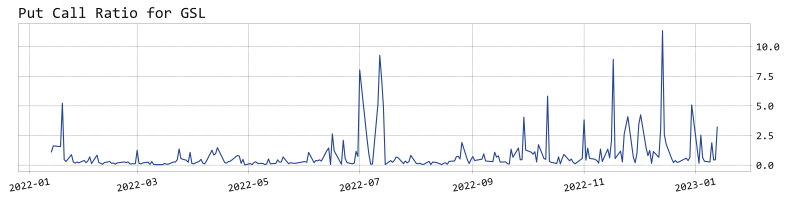

In [806]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [807]:
expiry_dates = openbb.stocks.options.expirations(symbol)
if (len(expiry_dates) > 0):
    exp = expiry_dates[0]
    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
else:
    option_chain = pd.DataFrame()


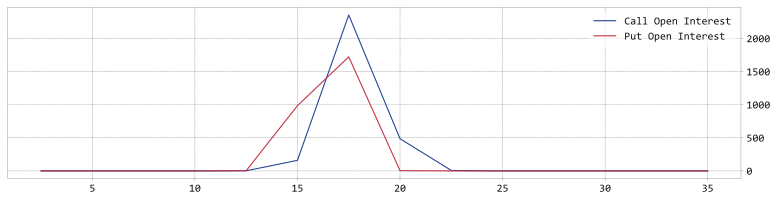

In [808]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    ax.plot(
        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
    )
    ax.plot(
        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
    )
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    vol_chart = f.getvalue().decode("utf-8")

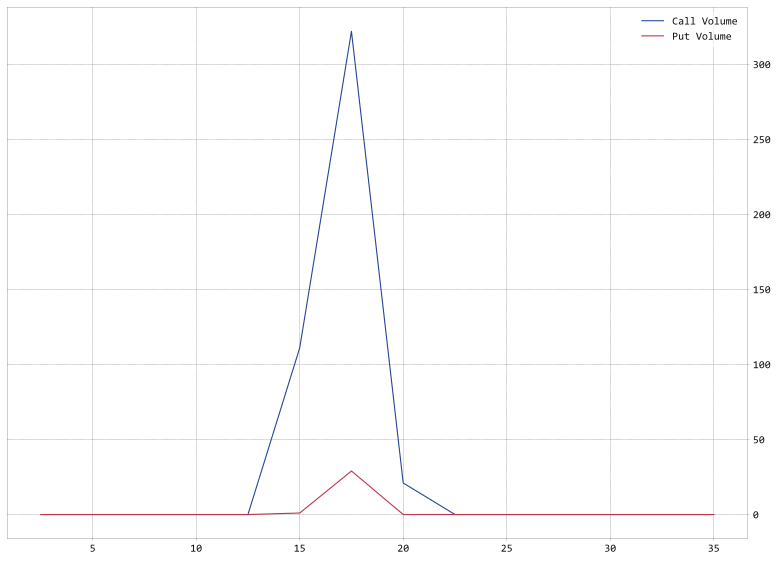

In [809]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    voi_chart = f.getvalue().decode("utf-8")

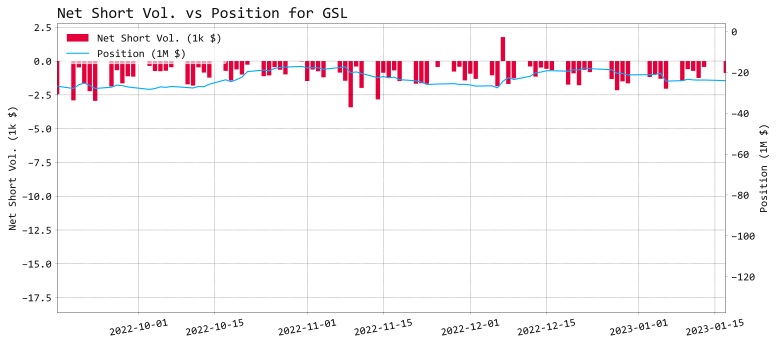

In [810]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

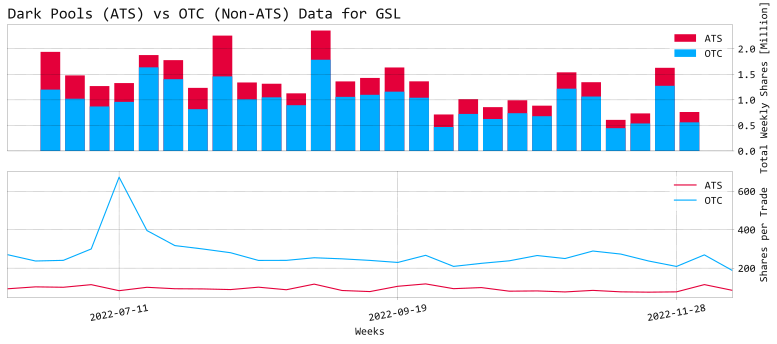

In [811]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

No congress trading data found

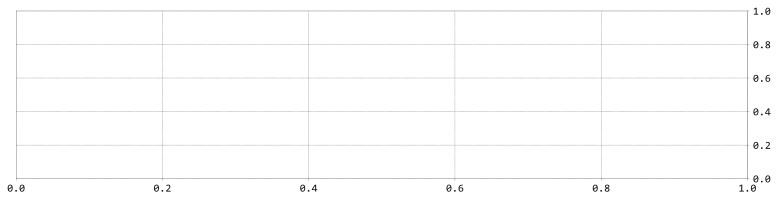

In [812]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

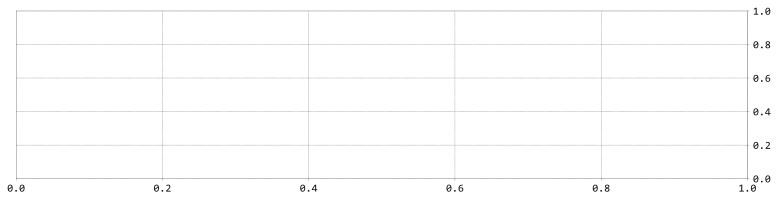

In [813]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

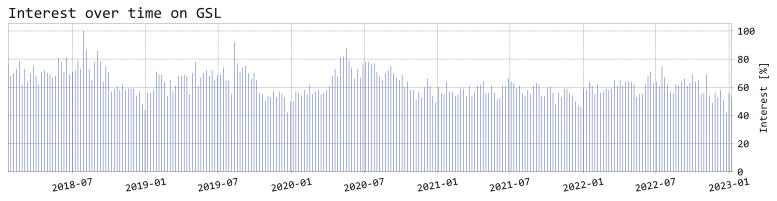

In [814]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

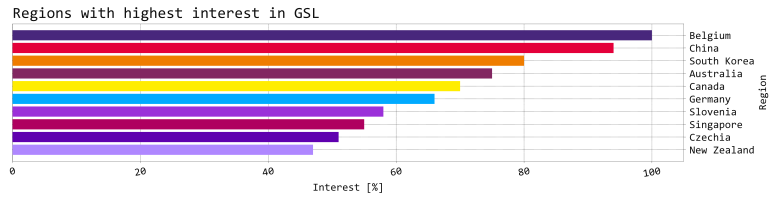

In [815]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")

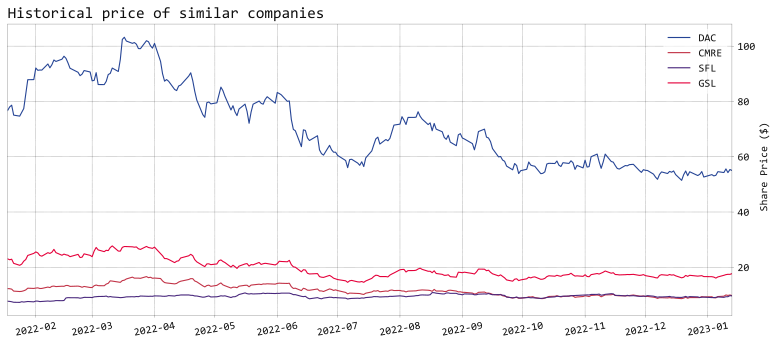

In [816]:
similar_companies_dict={'FTCO': ['GOLD','KGC','AU','AEM','NEM','FTCO'],
                        'AR': ['RRC', 'EQT','SWN','CNX','CHK','AR'],
                        'FLNG' : ['GLNG','SFL'],
                        'GSL' : ['DAC','CMRE','SFL']}
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

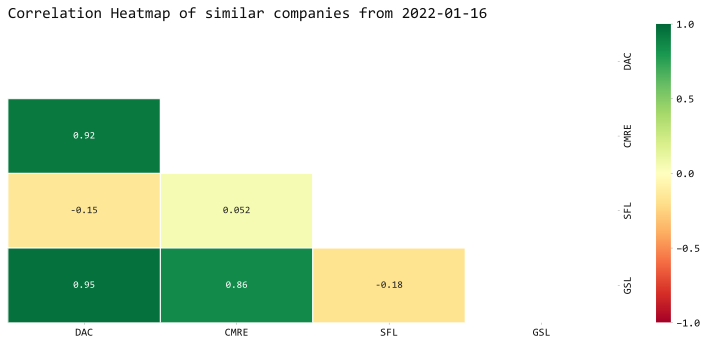

In [817]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

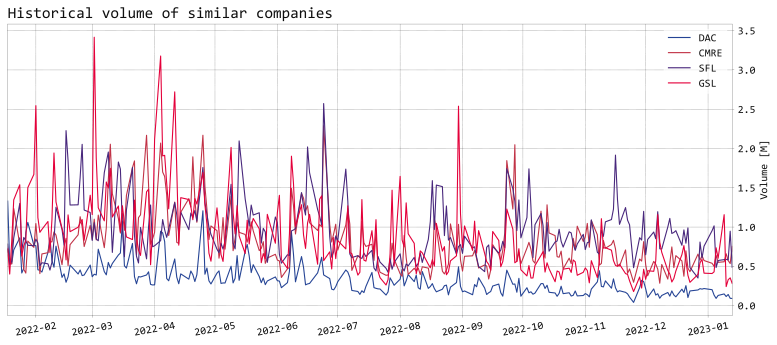

In [818]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

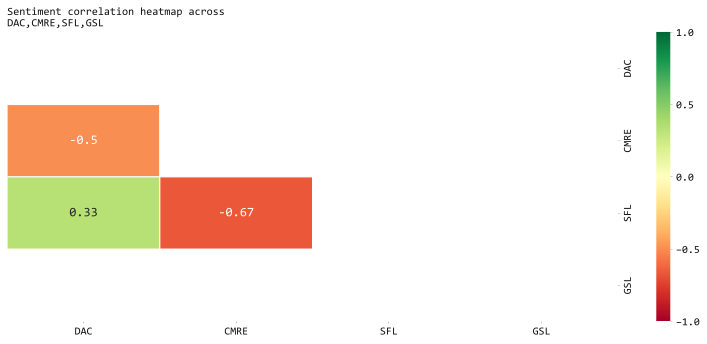

In [819]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [820]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,CMRE,1.260000e+09,2.47,2.76,1.11,0.60,1.96,12.70,0.470,0.0259,0.331
1,DAC,1.140000e+09,2.01,2.19,1.19,0.47,NaN,1.68,6.930,-0.2651,0.254
2,GSL,6.450300e+08,2.37,2.06,1.02,0.71,5.37,2.50,1.172,0.0795,0.198
3,SFL,1.360000e+09,5.95,10.44,2.18,1.15,6.70,8.03,1.573,-0.3791,-0.047


In [821]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross Margin,Operating Margin,Profit Margin
0,CMRE,0.0468,0.106,0.264,0.103,2.0,1.9,1.17,1.35,0.722,0.554,0.433
1,DAC,0.0538,0.153,0.246,0.136,2.3,2.3,0.34,0.38,0.801,0.629,0.599
2,GSL,0.0846,0.136,0.345,0.133,0.8,0.8,0.86,1.07,0.708,0.560,0.443
3,SFL,0.0946,0.065,0.228,0.072,0.3,NaN,1.40,2.34,0.717,0.487,0.375


In [822]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])

ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,CMRE,121430000.0,51940000.0,0.779,0.0,0.226,-0.0420,0.0353,2.92
1,DAC,20300000.0,10820000.0,0.587,0.0,0.214,-0.1943,0.0625,3.82
2,GSL,36650000.0,34050000.0,0.790,0.0,0.476,-0.1061,0.0851,5.84
3,SFL,126790000.0,116510000.0,0.434,0.0,0.346,-0.0464,0.0147,1.98


In [823]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [824]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

No quarterly government contracts found

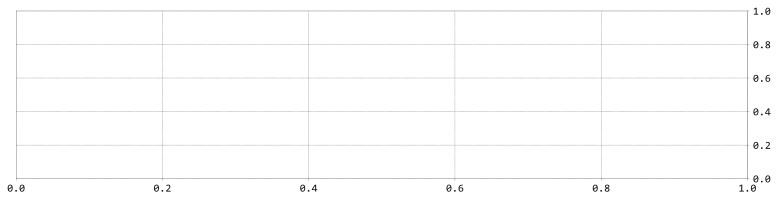

In [825]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [826]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

No corporate lobbying found

""


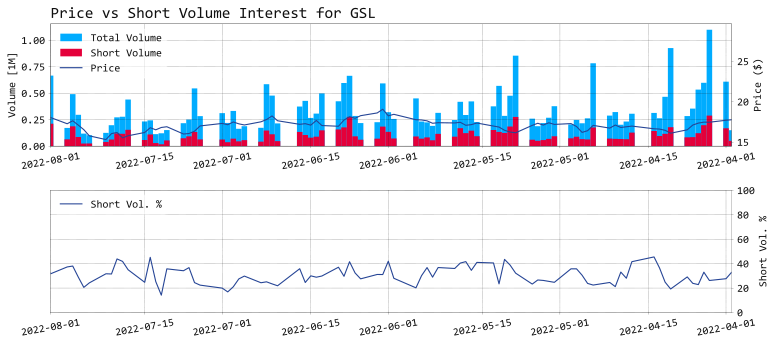

In [827]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

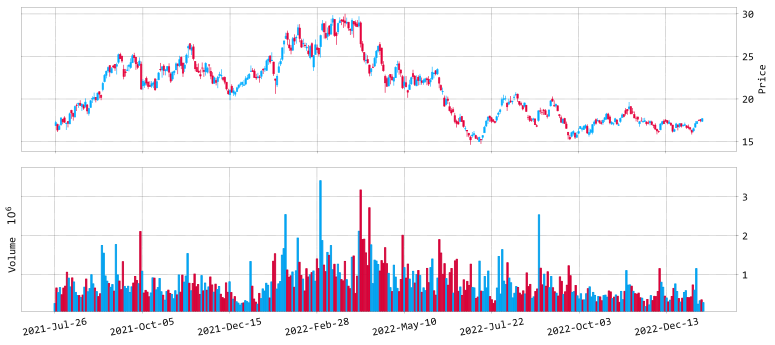

In [828]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

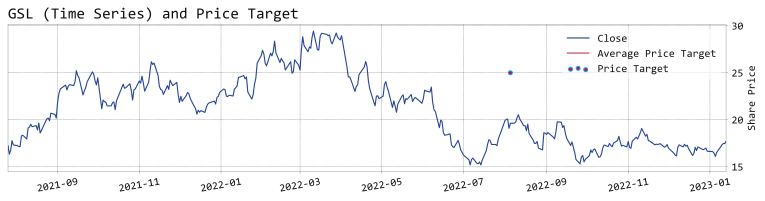

In [829]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [830]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

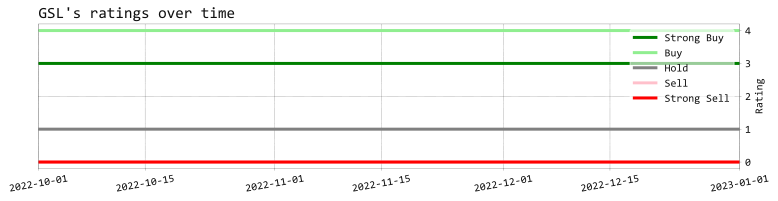

In [831]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

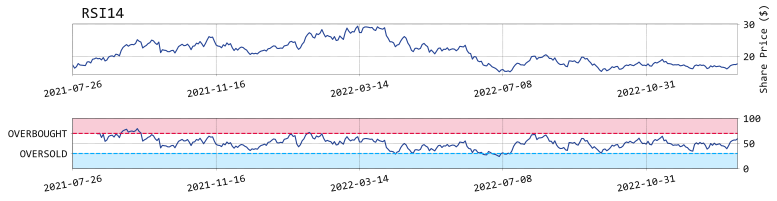

In [832]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [833]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

59.43

In [834]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [835]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

Error: "None of ['Date'] are in the columns"

empty


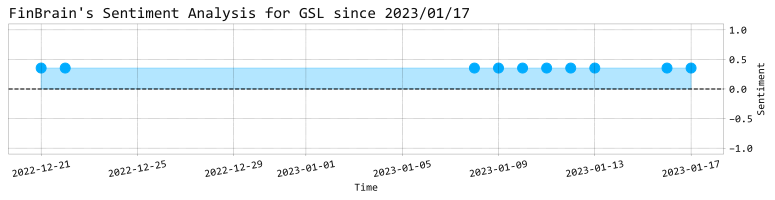

In [836]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [837]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [838]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 4936</br>\nLast 1 sentiment messages:</br>Bullish 100.0%</br>Bearish 0.0%'

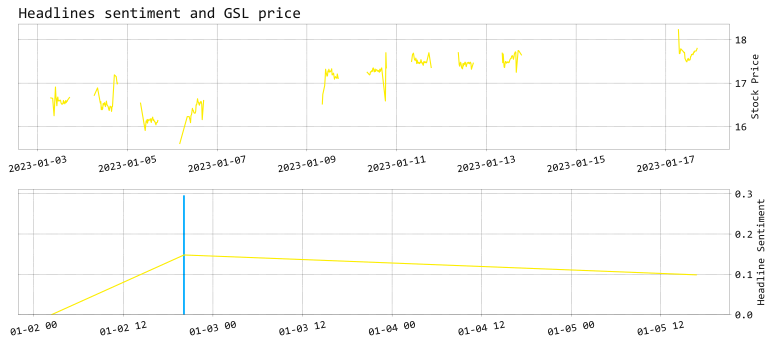

In [839]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [840]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for GSL with starting period 2019-08-06.

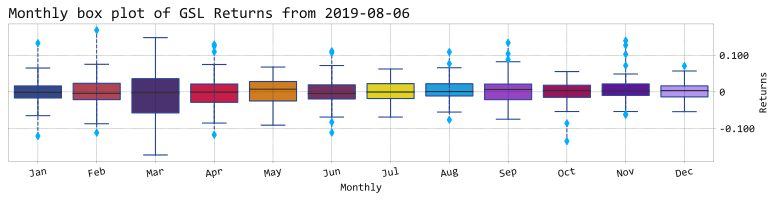

In [841]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

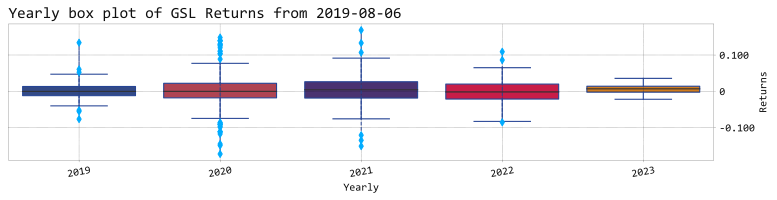

In [842]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [843]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for GSL

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

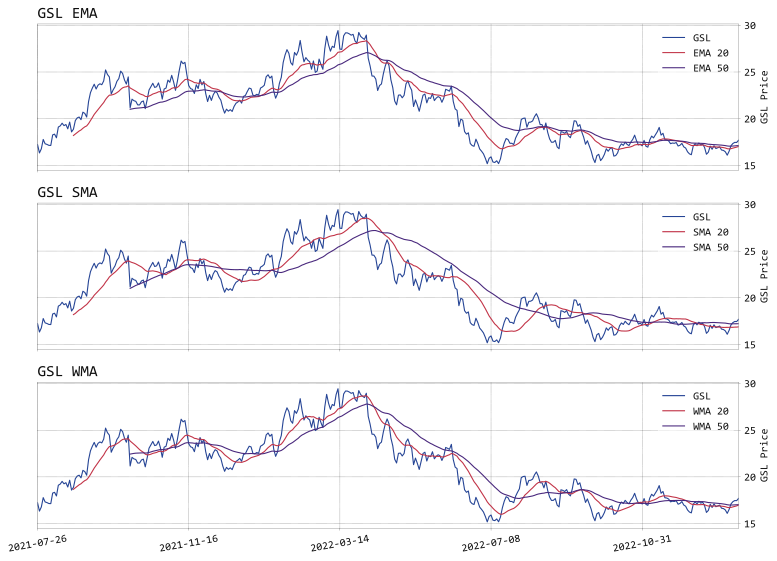

In [844]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

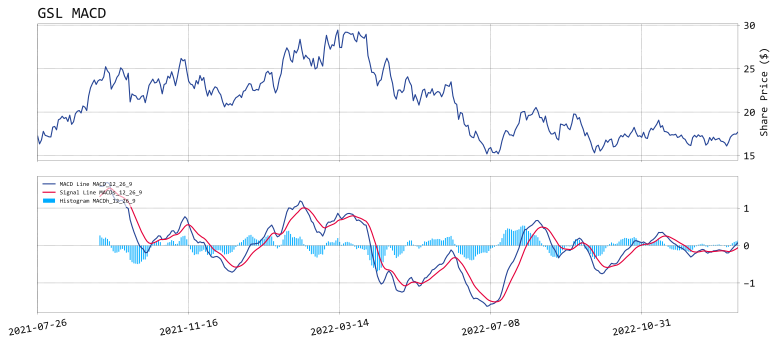

In [845]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

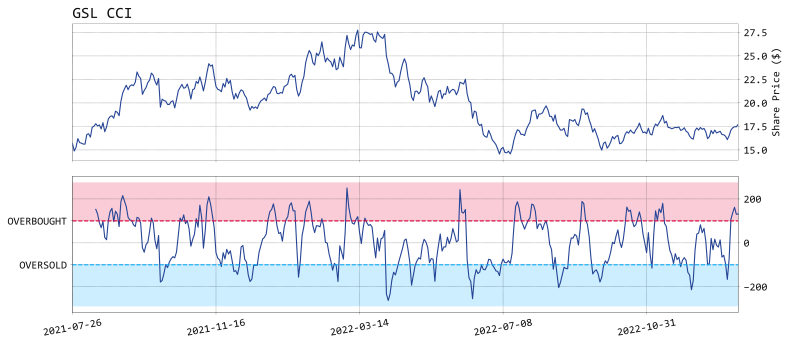

In [846]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

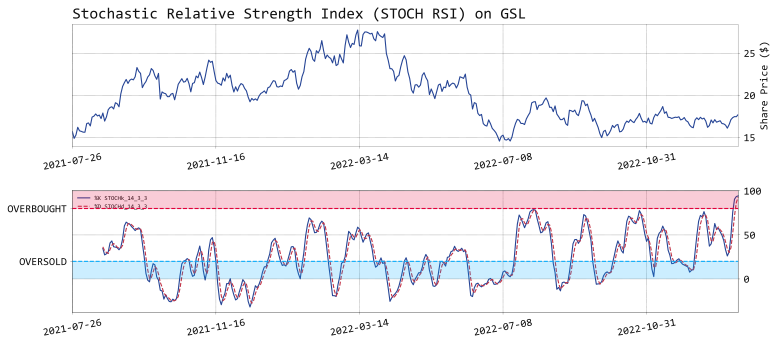

In [847]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

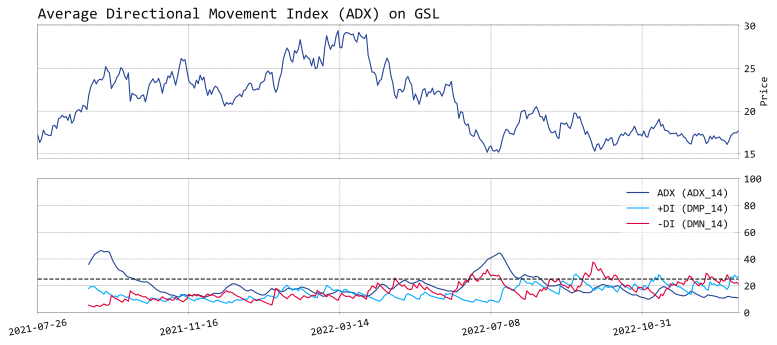

In [848]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

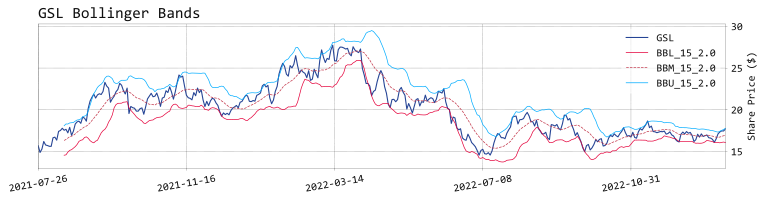

In [849]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

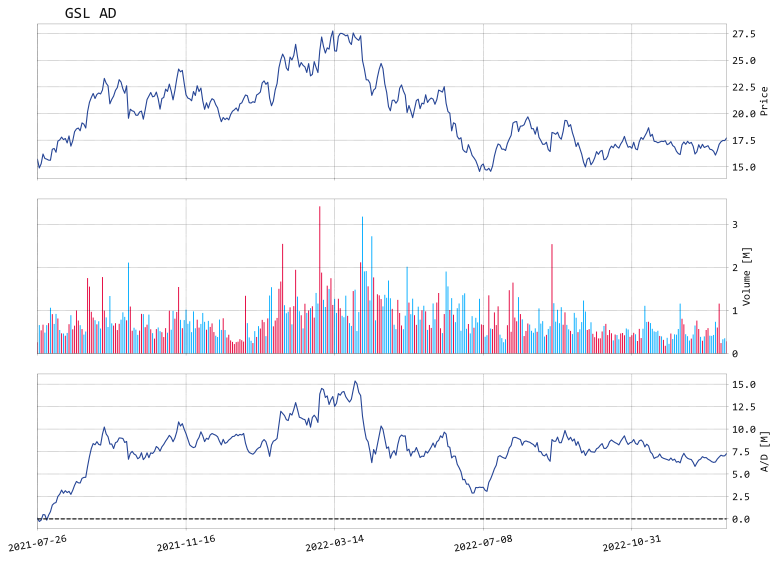

In [850]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [851]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
        {{
        "width": "1085",
        "height": "700",
        "colorTheme": "light",
        "isTransparent": false,
        "symbol": "{exchange}:{symbol}",
        "locale": "en"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
"""

body += widgets.add_tab("Summary", htmlcode, False)


htmlcode = f"""
<!-- TradingView Widget BEGIN -->
<div class="tradingview-widget-container">
  <div id="tradingview_fceac"></div>
  <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
  <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
  <script type="text/javascript">
  new TradingView.MediumWidget(
    {{
    "symbols": [
        [
        "{long_name}",
        "{exchange}:{symbol}|1D"
        ]
    ],
    "chartOnly": false,
    "width": "1085",
    "height": "700",
    "locale": "en",
    "colorTheme": "light",
    "autosize": false,
    "showVolume": false,
    "hideDateRanges": false,
    "hideMarketStatus": false,
    "scalePosition": "right",
    "scaleMode": "Normal",
    "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
    "fontSize": "10",
    "noTimeScale": false,
    "valuesTracking": "1",
    "chartType": "line",
    "container_id": "tradingview_fceac"
    }}
  );
  </script>
</div>
<!-- TradingView Widget END -->
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
     <div class="tweet-list">
        {% for tweet in tweets %}
        <div class="tweet">
            <div class="tweet-header">
                <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                <h3>{{ tweet.user.name }}</h3>                   
            </div>       
            <div class="tweet-body">
                <p>{{ tweet.full_text }}</p>
            </div>   
            {% if tweet.entities.media %}
                <div class="tweet-media">
                {% for media in tweet.entities.media %}
                    <img src="{{ media.media_url_https }}" alt="Tweet media">
                {% endfor %}
                </div>
            {% endif %}
            <div class="tweet-footer">
                {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                <p>{{ date }}</p>
                <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
            </div>
        </div>
        {% endfor %}
    </div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)
htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
        {{
        "colorTheme": "light",
        "isTransparent": false,
        "largeChartUrl": "",
        "displayMode": "regular",
        "width": "1085",
        "height": "800",
        "symbol": "{exchange}:{symbol}",
        "locale": "en"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
"""

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass


body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
if not option_chain.empty:
    htmlcode += widgets.row(
        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
    )
    htmlcode += widgets.row(
        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
    )
try:
    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
except:
    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

try:
    htmlcode = widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)


htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
        {{
        "interval": "1W",
        "width": "1085",
        "isTransparent": false,
        "height": "700",
        "symbol": "{exchange}:{symbol}",
        "showIntervalTabs": true,
        "locale": "en",
        "colorTheme": "light"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)